In [990]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os

import math
from datetime import datetime

from nltk.corpus import stopwords

In [991]:
stopwords = stopwords.words("english")
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [992]:
## getting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [993]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [994]:
## checking for missing
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [995]:
## checking the keyword column
df_train["keyword"].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [996]:
df_train[df_train["location"].notna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


In [1016]:
df_train["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [997]:
## checking the nature of the tweets

df_train["text"].sample(5).values

array(["Today is the day Hiroshima got Atomic bomb 70 years ago.  - The 'sanitised narrative' of Hiroshima's atomic bombing http://t.co/GKpANz7vg0",
       "@Drake is body bagging meek meanwhile he's on tour with Nicki all hush hush...he's put 2 diss tracks out and meek 0 but dude started it lol",
       "Pakistan says army helicopter has crashed in country's restive northwest killing at least 8 http://t.co/QV1RMZI3J1",
       'I got evacuated from the cinema 30 mins through Inside Out\r\nKill me please',
       "don't get on I77 south... huge wreck and airlift and maybe some deaths interstate is completely blocked"],
      dtype=object)

In [998]:
## for cleaning function
## - remove urls
## - remove # tags
## - remove html special characters eg &amp;
## - remove @text
## - remove [01:04 UTC]
## - strip

In [999]:
import re

## function to preprocessing of text
def process_text(text):
    ## patterns to remove
    rem_pat_1 = "([#@]|https?:)\S*"
    rem_pat_2 = "&\S+;"
    rem_pat_3 = "\[\d+:\d+.+\]" ## removing timestamp. eg. [01:04 UTC]
    rem_pat_4 = "[\-_.+]" ## to remove symbols (make sure to bring last to avoid affecting first two patterns)
    combined_rem_pat = f"({rem_pat_1})|({rem_pat_2})|({rem_pat_3})|({rem_pat_4})"

    text = re.sub(combined_rem_pat, "", text) ## removing text that match patterns
    text = text.strip() ## removing trailing white spaces
    text = text.lower() ## lowercasing

    return text

## function for tokenizing of string
def tokenize(text):
    return re.split("\s+", text)

## function to remove stop words
def remove_stopwords(token_list):
    l = []
    for word in token_list:
        if word not in stopwords:
            l.append(word)
    return l

def full_text_process(text):
    text = process_text(text)
    text = tokenize(text)
    # text = remove_stopwords(text)
    return text

In [1000]:
## getting the training and testing processed data
## train
train_text = df_train["text"].apply(lambda x: full_text_process(x)).values
train_target = df_train["target"].values

In [1001]:
train_text

array([list(['deeds', 'reason', 'may', 'allah', 'forgive', 'us']),
       list(['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']),
       list(['residents', 'asked', "'shelter", "place'", 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']),
       ..., list(['m194', '?5km', 'volcano', 'hawaii']),
       list(['police', 'investigating', 'ebike', 'collided', 'car', 'little', 'portugal', 'ebike', 'rider', 'suffered', 'serious', 'nonlife', 'threatening', 'injuries']),
       list(['latest:', 'homes', 'razed', 'northern', 'california', 'wildfire', 'abc', 'news'])],
      dtype=object)

In [1002]:
## creating word dictionary
word2idx = {"<pad>": 0}
count = 1

for l in train_text:
    for i in range(len(l)):
        if l[i] not in word2idx:
            word2idx[l[i]] = count
            count+=1

        l[i] = word2idx[l[i]]

In [1003]:
## function to convert token list to integer list
def token_to_int(text_data, word2idx):
    for i in range(len(text_data)):
        idx_list = []
        for word in text_data[i]:
            if word in word2idx:
                idx_list.append(word2idx[word])
        text_data[i] = idx_list

In [1004]:
## creating train and validation data
X_train, X_test, y_train, y_test = train_test_split(train_text, train_target, test_size=0.3, shuffle=True)

In [1005]:
## creating data loaders
def data_loader(inputs, targets, batch_size=64):
    inputs, targets = shuffle(inputs, targets)
    n = len(inputs)
    num_batches = math.ceil(n/batch_size)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx+batch_size, n)

        ## getting the batch data
        inputs_batch = inputs[start_idx:end_idx]
        targets_batch = targets[start_idx:end_idx]

        ## padding the inputs
        max_len = max([len(l) for l in inputs_batch])

        for j in range(len(inputs_batch)):
            pad_len = max_len - len(inputs_batch[j])
            inputs_batch[j] = [0]*pad_len + inputs_batch[j]

        yield np.array([*inputs_batch]),  targets_batch.reshape(-1,1).astype(np.float32)
        
## creating data loader for submissing data
def data_loader_no_target(inputs, batch_size=64):
    n = len(inputs)
    num_batches = math.ceil(n/batch_size)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx+batch_size, n)

        ## getting the batch data
        inputs_batch = inputs[start_idx:end_idx]

        ## padding the inputs
        max_len = max([len(l) for l in inputs_batch])

        for j in range(len(inputs_batch)):
            pad_len = max_len - len(inputs_batch[j])
            inputs_batch[j] = [0]*pad_len + inputs_batch[j]

        yield np.array([*inputs_batch])

In [1006]:
batch_size = 128
train_loader = lambda: data_loader(X_train, y_train, batch_size=batch_size)
test_loader = lambda: data_loader(X_test, y_test, batch_size=batch_size)

In [1007]:
## creating model
class Model(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(Model, self).__init__()
        self.V = vocab_size
        self.D = embed_size
        self.M = hidden_size
        self.L = num_layers
    
        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
    
        self.fc = nn.Linear(self.M, 1)

    def forward(self, X):
        c0 = torch.zeros(self.L, X.size(0), self.M)
        h0 = torch.zeros(self.L, X.size(0), self.M)

        out = self.embed(X)

        out, _ = self.rnn(out, (c0,h0))
        
        out, _ = torch.max(out, 1) ## global max pooling
        # out = out[:,-1,:] ## selecting last layer

        out = self.fc(out)

        return out

In [1008]:
model = Model(len(word2idx), 10, 15, 1)

In [1009]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [1010]:
model.to(device)

Model(
  (embed): Embedding(17111, 10)
  (rnn): LSTM(10, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [1011]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [1012]:
## creating training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=50):
    train_losses = []
    test_losses = []
    
    for it in range(epochs):
        t0 = datetime.now()

        epoch_losses = []
        model.train()
        for inputs, targets in train_loader():
            inputs = torch.from_numpy(inputs).to(device)
            targets = torch.from_numpy(targets).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        train_losses.append(np.mean(epoch_losses))
            
        epoch_losses = []
        model.eval()
        for inputs, targets in test_loader():
            inputs = torch.from_numpy(inputs).to(device)
            targets = torch.from_numpy(targets).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            epoch_losses.append(loss.item())

        test_losses.append(np.mean(epoch_losses))

        dt = datetime.now() - t0

        print(f"Epoch: {it+1}/{epochs}, Train Loss: {train_losses[it]}, Test Loss: {test_losses[it]}, Duration: {dt}")

    return train_losses, test_losses

In [1013]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch: 1/15, Train Loss: 0.6849175478730883, Test Loss: 0.6830279065503014, Duration: 0:00:00.489725
Epoch: 2/15, Train Loss: 0.6807550092538198, Test Loss: 0.681388646364212, Duration: 0:00:00.467173
Epoch: 3/15, Train Loss: 0.6780636778899601, Test Loss: 0.6783455477820503, Duration: 0:00:00.483277
Epoch: 4/15, Train Loss: 0.672963715734936, Test Loss: 0.6744159493181441, Duration: 0:00:00.483186
Epoch: 5/15, Train Loss: 0.6650157258624122, Test Loss: 0.667954706483417, Duration: 0:00:00.467664
Epoch: 6/15, Train Loss: 0.6518661053407759, Test Loss: 0.6584391991297404, Duration: 0:00:00.480305
Epoch: 7/15, Train Loss: 0.6314811337561834, Test Loss: 0.6447111997339461, Duration: 0:00:00.469516
Epoch: 8/15, Train Loss: 0.602206601983025, Test Loss: 0.6288462844159868, Duration: 0:00:00.465531
Epoch: 9/15, Train Loss: 0.5660978555679321, Test Loss: 0.6154881252182854, Duration: 0:00:00.528763
Epoch: 10/15, Train Loss: 0.527130283060528, Test Loss: 0.6049738427003225, Duration: 0:00:00.4

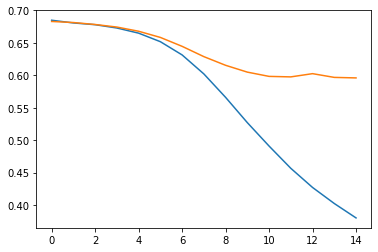

In [1014]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

In [1015]:
## checking accuracy
model.eval()
with torch.no_grad():
    sample_num = 0
    total = 0
    for inputs, targets in train_loader():
        inputs = torch.from_numpy(inputs).to(device)
        targets = torch.from_numpy(targets).to(device)
        preds = model(inputs)
        preds = preds > 0
        total += (preds == targets).sum().item()
        sample_num += inputs.size(0)

    train_acc = total/sample_num
    
    sample_num = 0
    total = 0
    for inputs, targets in test_loader():
        inputs = torch.from_numpy(inputs).to(device)
        targets = torch.from_numpy(targets).to(device)
        preds = model(inputs)
        preds = preds > 0
        total += (preds == targets).sum().item()
        sample_num += inputs.size(0)

    test_acc = total/sample_num

    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.8583, Test Accuracy: 0.7084


#### Prediction on submission data

In [989]:
## test
test_text = df_test["text"].apply(lambda x: full_text_process(x)).values

KeyboardInterrupt: 

In [ ]:
## converting text token list to index list
token_to_int(test_text, word2idx)

In [ ]:
submission_loader = lambda: data_loader_no_target(test_text, batch_size=batch_size)

In [ ]:
sub_preds = np.array([])
model.eval()
with torch.no_grad():
    for inputs in submission_loader():
        inputs = torch.from_numpy(inputs).to(device)
        preds = model(inputs)
        preds = preds > 0
        preds = preds.numpy().astype(int).flatten()
        sub_preds = np.concatenate([sub_preds, preds])

In [ ]:
## creating submission dataframe
ids = df_test["id"].values

sub_df = pd.DataFrame({"id": ids, "target": sub_preds.astype(int)})

## saving as csv
if not os.path.exists("x__submissions"):
    os.mkdir("x__submissions")

sub_df.to_csv("x__submissions/sub3.csv", index=False)

In [ ]:
sub_df